In [1]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [ ]:
from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapOnImage

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
#         iaa.Scale((640, 480)),
#         iaa.Fliplr(0.5),
          iaa.Sometimes(0.8,iaa.PerspectiveTransform(scale=(0,0.2)))  
#         iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.6))),
#         iaa.Sometimes(0.1, iaa.AverageBlur(1.2)),
#         iaa.Sometimes(1, iaa.Affine(rotate=(-20, 20),order=[0, 1],translate_px={"x":(-2, 2),"y":(-2,2)},mode='symmetric')),
#         iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25))),
#         iaa.Sometimes(0.1, iaa.SaltAndPepper(0.05,False)),
#         iaa.Invert(0.5),
#         iaa.Add((-5, 5)), # change brightness of images (by -10 to 10 of original value)
#         iaa.AdditiveGaussianNoise(-1,1)
#         iaa.Sometimes(0.2,iaa.GammaContrast(2))
            
#         iaa.AddToHueAndSaturation(from_colorspace="GRAY",value=(-20, 20))  #Hue-> color, saturation -> saido
    ])
    def __call__(self, img, mask=None):
        img = np.array(img)        
        return self.aug.augment_image(image=img)
#         return self.aug(image=img, segmentation_maps=label)

In [2]:
trans = transforms.Compose([
        transforms.ColorJitter(0.5,0.5,0,0),
#         transforms.RandomAffine(degrees=15,translate=(0.25,0.25),scale=(0.75,1.25),shear=8),  #normal    
#         transforms.Resize((224,224)), #For resnet
#         transforms.RandomAffine(degrees=2,translate=(0.05,0.05)), #For 01 classifier
#         transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),  #Used in Chris Deotte avgpool
#         transforms.RandomAffine(degrees=10,translate=(0.2,0.2),scale=[0.9,1.1]), #For native distinguisher
#         ImgAugTransform(),
#         lambda x: Image.fromarray(x),
        transforms.RandomAffine(degrees=15,translate=(0.015,0.015),scale=(0.9,1.1),shear=3),  #for Se_res18    
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1  
#         transforms.Normalize(mean=[0.08889289],std=[0.24106446])  #train_large dataset distribution
#         transforms.Normalize(mean=[0.08229437],std=[0.23876116]) #train dataset dist
#         transforms.Normalize(mean=[0.09549136],std=[0.24336776]) #dig_augmented distribution
    ])

trans_dig = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
#         transforms.Normalize(mean=[0.08889289],std=[0.24106446])  #train_large dataset distribution
#         transforms.Normalize(mean=[0.08229437],std=[0.23876116]) #train dataset dist
#         transforms.Normalize(mean=[0.09549136],std=[0.24336776]) #dig_augmented distribution
    ])

trans_val = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
    ])


In [ ]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%5120 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()


# KMnist Dataset Definition

In [3]:
# global_data = pd.read_csv("./dataset/train.csv")
# global_aug_dig = pd.read_csv("./dataset/Dig-Mnist-Augmented.csv")
global_data = pd.read_csv("./dataset/Dig-MNIST.csv")
# global_test_data = pd.read_csv("./dataset/test.csv")
# global_pseudo_data = pd.read_csv("./dataset/train_test_psuedo_65k.csv")
# global_critic01_data = pd.read_csv("./dataset/critic01_20k.csv")
# global_data = pd.read_csv("./dataset/train_digtop1_69548.csv")
# global_data = pd.read_csv("./dataset/digtop1_9548.csv")


class KMnistDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None,indices=None):
        self.is_validate = is_validate
        self.data = global_data
        if data_len == None:
            data_len = len(self.data)
        
        self.indices = indices
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
        idx += self.offset
        idx = self.indices[idx]
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

In [ ]:
batch_size = 1
num_workers = 0
vr = 0
k = 5
indices_len = 60000
# indices_len = 10240
# indices_len = 120000

###Single dataset
indices = np.arange(indices_len)
train_dataset = KMnistDataset(data_len=None,is_validate=False,validate_rate=vr,indices=indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution: mean={},std={}".format(mean, std))

for idx,data in enumerate(train_loader):
    img, label = data
    img, label = img.to(device), label.to(device)
#     img = img.cpu().numpy()
#     img = np.uint8(img*255).reshape(batch_size,-1)
#     label = label.cpu().numpy()
    
    fig,axes = plt.subplots(1,1,figsize=(2,2))
    img = img[0]
    origin_img = img.clone()
    axes.imshow(origin_img.cpu().numpy().reshape(28,28),cmap='gray')
#     img = transforms.functional.adjust_brightness(img., 0.1)
#     axes[1].imshow(img.cpu().numpy().reshape(28,28),cmap='gray')
    plt.pause(.1)
    if idx!=0 and idx%10 ==0 :
        stop
        input('stop')


# Visualize image

In [ ]:
global_data = pd.read_csv("./dataset/critic01_20k.csv")

In [ ]:
for idx in range(0,100):

    i = idx
    img = global_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = global_data.iloc[i, 0]
    
    if i%10==0:
        plt.pause(.1)
        fig, axes = plt.subplots(1,10,figsize=(16,2))
    axes[i%10].imshow(img,cmap="gray")
    
    #     img = trans(img).cpu().numpy().reshape(28,28)
    #     img = transforms.functional.adjust_brightness(img, 0.01)
    #     img = transforms.functional.adjust_contrast(img, 0.01)
    #     img = transforms.functional.adjust_saturation(img, 5)
#         axes[j][1].imshow(img,cmap="gray")
    
#     img = global_data_dig.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
#     img = Image.fromarray(img)
#     label = global_data_dig.iloc[i, 0]
#     axes[2].imshow(img,cmap="gray")
#     img = trans(img).cpu().numpy().reshape(28,28)
#     axes[3].imshow(img,cmap="gray")
    

    print("Label:",label)

# data.head(5)

# Test Imgaug Speed

In [ ]:
time_counter = np.zeros((5,))
for i in range(0,1000):
    img = global_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = data.iloc[i, 0]
    img = np.array(img)
    t = time.clock()
    iaa.GaussianBlur(sigma=(0, 0.6)).augment_image(img)
    time_counter[0] += time.clock()-t
    
    t = time.clock()
    iaa.AverageBlur(2).augment_image(img)
    time_counter[1] += time.clock()-t
    
    
    t = time.clock()
    iaa.MedianBlur(3).augment_image(img)
    time_counter[2] += time.clock()-t
    
    t = time.clock()
    iaa.MotionBlur(180,-1).augment_image(img)
    time_counter[3] += time.clock()-t    

print(time_counter/1000)


# Diff between train_set and Dig_val set

# Sub: Convnet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class convNet(nn.Module):
    def __init__(self,in_channels):
        super(convNet,self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,5,1,2)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c4 = nn.Conv2d(64,128,3,1,0)
        self.bn4 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c5 = nn.Conv2d(128,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,5,1,2)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)        
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c7 = nn.Conv2d(128,256,3,1,0)
        self.bn7 = nn.BatchNorm2d(256,1e-3,0.01)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*1*1,256)
        self.bn8 = nn.BatchNorm1d(256,1e-3,0.01)
        
        self.fc2 = nn.Linear(256,128)
        self.bn9 = nn.BatchNorm1d(128,1e-3,0.01)
        
        self.out = nn.Linear(128,10)
        
        self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.relu(self.c1(x)))
        x = self.bn2(F.relu(self.c2(x)))
        x = self.bn3(F.relu(self.c3(x)))
        x = self.m1(x)
        x = self.d1(x)
        
        x = self.bn4(F.relu(self.c4(x)))
        x = self.bn5(F.relu(self.c5(x)))
        x = self.bn6(F.relu(self.c6(x)))
        x = self.m2(x)
        x = self.d2(x)
        
        x = self.bn7(F.relu(self.c7(x)))
        x = self.m3(x)
        x = self.d3(x)        
        
        x = x.view(-1, 256*1*1) #reshape
        
        x = self.bn8(self.fc1(x))
        x = self.bn9(self.fc2(x))
        
        return self.out(x)
    
    def init_linear_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in')
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in')

# Sub: Conv_avgpool

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class convNet_avp(nn.Module):
    def __init__(self,in_channels):
        super(convNet_avp,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,5,2,2)  #Use strides 2 instead of maxpooling
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.d1 = nn.Dropout(0.2)
        
        self.c4 = nn.Conv2d(64,128,3,1,0)
        self.bn4 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c5 = nn.Conv2d(128,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,5,2,2)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)        
        self.d2 = nn.Dropout(0.2)
        
        self.c7 = nn.Conv2d(128,256,4,1,0)
        self.bn7 = nn.BatchNorm2d(256,1e-3,0.01)
        self.d3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(256*1*1,256)
        self.bn8 = nn.BatchNorm1d(256,1e-3,0.01)
        
        self.out = nn.Linear(256,10)
#         self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.relu(self.c1(x)))
        x = self.bn2(F.relu(self.c2(x)))
        x = self.bn3(F.relu(self.c3(x)))
        x = self.d1(x)
        
        x = self.bn4(F.relu(self.c4(x)))
        x = self.bn5(F.relu(self.c5(x)))
        x = self.bn6(F.relu(self.c6(x)))
        x = self.d2(x)
        
        x = self.bn7(F.relu(self.c7(x)))
        x = self.d3(x)

        x = x.view(-1, 256*1*1) #reshape
        x = self.bn8(self.fc1(x))
        return self.out(x)

# Sub: SE_Net3

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Seq_Ex_Block(nn.Module):
    def __init__(self, in_ch, r=16):
        super(Seq_Ex_Block, self).__init__()
        self.se = nn.Sequential(
            GlobalAvgPool(),
            nn.Linear(in_ch, in_ch//r),
            nn.ReLU(inplace=True),
            nn.Linear(in_ch//r, in_ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        se_weight = self.se(x).unsqueeze(-1).unsqueeze(-1)
#         print(f'x:{x.sum()}, x_se:{x.mul(se_weight).sum()}')
        return x.mul(se_weight)

class GlobalAvgPool(nn.Module):
    def __init__(self):
        super(GlobalAvgPool, self).__init__()
    def forward(self, x):
        return x.view(*(x.shape[:-2]),-1).mean(-1)

class SE_Net3(nn.Module):
    def __init__(self,in_channels):
        super(SE_Net3,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c4 = nn.Conv2d(64,64,5,1,2)
        self.bn4 = nn.BatchNorm2d(64,1e-3,0.01)        
        
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.5)
        
        self.c5 = nn.Conv2d(64,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,3,1,0)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c7 = nn.Conv2d(128,128,3,1,1)
        self.bn7 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c8 = nn.Conv2d(128,128,5,1,2)
        self.bn8 = nn.BatchNorm2d(128,1e-3,0.01)
        
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.5)
        
        self.c9 = nn.Conv2d(128,256,3,1,0)
        self.bn9 = nn.BatchNorm2d(256,1e-3,0.01)
        self.c10 = nn.Conv2d(256,256,3,1,1)
        self.bn10 = nn.BatchNorm2d(256,1e-3,0.01)
        
        self.se1 = Seq_Ex_Block(in_ch=256,r=16)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256*1*1,256)
        self.bn11 = nn.BatchNorm1d(256,1e-3,0.01)
        self.out = nn.Linear(256,10)
        
        self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.leaky_relu(self.c1(x),0.05))
        x = self.bn2(F.leaky_relu(self.c2(x),0.05))
        x = self.bn3(F.leaky_relu(self.c3(x),0.05))
        x = self.bn4(F.leaky_relu(self.c4(x),0.05))
        x = self.d1(self.m1(x))
        
        x = self.bn5(F.leaky_relu(self.c5(x),0.05))
        x = self.bn6(F.leaky_relu(self.c6(x),0.05))
        x = self.bn7(F.leaky_relu(self.c7(x),0.05))
        x = self.bn8(F.leaky_relu(self.c8(x),0.05))
        x = self.d2(self.m2(x))
        
        x = self.bn9(F.leaky_relu(self.c9(x),0.05))
        x = self.bn10(F.leaky_relu(self.c10(x),0.05))
        x = self.se1(x)
        x = self.d3(self.m3(x))
        
        x = x.view(-1, 256*1*1) #reshape
        x = self.bn11(F.leaky_relu(self.fc1(x),0.05))
        return self.out(x)
    
    def init_linear_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in')


# Sub:SE_Net2

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Seq_Ex_Block(nn.Module):
    def __init__(self, in_ch, r=16):
        super(Seq_Ex_Block, self).__init__()
        self.se = nn.Sequential(
            GlobalAvgPool(),
            nn.Linear(in_ch, in_ch//r),
            nn.ReLU(inplace=True),
            nn.Linear(in_ch//r, in_ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        se_weight = self.se(x).unsqueeze(-1).unsqueeze(-1)
#         print(f'x:{x.sum()}, x_se:{x.mul(se_weight).sum()}')
        return x.mul(se_weight)

class GlobalAvgPool(nn.Module):
    def __init__(self):
        super(GlobalAvgPool, self).__init__()
    def forward(self, x):
        return x.view(*(x.shape[:-2]),-1).mean(-1)

class SE_Net2(nn.Module):
    def __init__(self,in_channels):
        super(SE_Net2,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,5,1,2)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.se1 = Seq_Ex_Block(in_ch=64,r=8)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.4)
        
        self.c4 = nn.Conv2d(64,128,3,1,0)
        self.bn4 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c5 = nn.Conv2d(128,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,5,1,2)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)
        self.se2 = Seq_Ex_Block(in_ch=128,r=8)
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.4)
        
        self.c7 = nn.Conv2d(128,256,3,1,0)
        self.bn7 = nn.BatchNorm2d(256,1e-3,0.01)
        self.se3 = Seq_Ex_Block(in_ch=256,r=8)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(256*1*1,256)
        self.bn8 = nn.BatchNorm1d(256,1e-3,0.01)
        
        self.out = nn.Linear(256,10)
        
        self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.leaky_relu(self.c1(x),0.1))
        x = self.bn2(F.leaky_relu(self.c2(x),0.1))
        x = self.bn3(F.leaky_relu(self.c3(x),0.1))
        x = self.se1(x)
        x = self.d1(self.m1(x))
        
        x = self.bn4(F.leaky_relu(self.c4(x),0.1))
        x = self.bn5(F.leaky_relu(self.c5(x),0.1))
        x = self.bn6(F.leaky_relu(self.c6(x),0.1))
        x = self.se2(x)
        x = self.d2(self.m2(x))
        
        x = self.bn7(F.leaky_relu(self.c7(x),0.1))
        x = self.se3(x)
        x = self.d3(self.m3(x))
        
        x = x.view(-1, 256*1*1) #reshape
        x = self.bn8(F.relu(self.fc1(x),0.1))
        return self.out(x)
    
    def init_linear_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in')


class convNet(nn.Module):
    def __init__(self,in_channels):
        super(convNet,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,5,1,2)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c4 = nn.Conv2d(64,128,3,1,0)
        self.bn4 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c5 = nn.Conv2d(128,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,5,1,2)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)        
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c7 = nn.Conv2d(128,256,3,1,0)
        self.bn7 = nn.BatchNorm2d(256,1e-3,0.01)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*1*1,256)
        self.bn8 = nn.BatchNorm1d(256,1e-3,0.01)
        
        self.fc2 = nn.Linear(256,128)
        self.bn9 = nn.BatchNorm1d(128,1e-3,0.01)
        
        self.out = nn.Linear(128,10)
        
        self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.relu(self.c1(x)))
        x = self.bn2(F.relu(self.c2(x)))
        x = self.bn3(F.relu(self.c3(x)))
        x = self.m1(x)
        x = self.d1(x)
        
        x = self.bn4(F.relu(self.c4(x)))
        x = self.bn5(F.relu(self.c5(x)))
        x = self.bn6(F.relu(self.c6(x)))
        x = self.m2(x)
        x = self.d2(x)
        
        x = self.bn7(F.relu(self.c7(x)))
        x = self.m3(x)
        x = self.d3(x)        
        
        x = x.view(-1, 256*1*1) #reshape
        
        x = self.bn8(self.fc1(x))
        x = self.bn9(self.fc2(x))
        
        return self.out(x)
    
    def init_linear_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in')
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in')
        
class convNet_native(nn.Module):
    def __init__(self,in_channels):
        super(convNet_native,self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=5,stride=1,padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.c2 = nn.Conv2d(64,64,5,1,2)
        self.bn2 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c3 = nn.Conv2d(64,128,5,1,2)
        self.bn3 = nn.BatchNorm2d(128,0.1)
        self.c4 = nn.Conv2d(128,128,5,1,2)
        self.bn4 = nn.BatchNorm2d(128,0.1)
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c5 = nn.Conv2d(128,256,3,1,1)
        self.bn5 = nn.BatchNorm2d(256,0.1)
        self.c6 = nn.Conv2d(256,256,3,1,1)
        self.bn6 = nn.BatchNorm2d(256,0.1)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)

        self.fc = nn.Linear(256*3*3,256)  #layer for binary entropy
        self.d4 = nn.Dropout(0.2)
        self.out = nn.Linear(256,2)
        
    def forward(self,x):
        x = F.leaky_relu(self.bn1(self.c1(x)),negative_slope=0.1)
        x = F.leaky_relu(self.bn2(self.c2(x)),0.1)
        x = self.m1(x)
        x = self.d1(x)
        
        x = F.leaky_relu(self.bn3(self.c3(x)),0.1)
        x = F.leaky_relu(self.bn4(self.c4(x)),0.1)
        x = self.m2(x)
        x = self.d2(x)
        
        x = F.leaky_relu(self.bn5(self.c5(x)),0.1)
        x = F.leaky_relu(self.bn6(self.c6(x)),0.1)
        x = self.m3(x)
        x = self.d3(x)
        
        x = x.view(-1, 256*3*3) #reshape
        x_b = F.leaky_relu(self.fc(x),0.1)
        x_b = self.d4(x_b)
        return self.out(x_b)
        

In [ ]:
# native_model = convNet_native(in_channels=1)
# native_model.cuda()
# native_model.load_state_dict(torch.load("Kmnist_saved_model/ensemble/native_classifier/Fold0_loss0.0242_acc_b99.704_without_aug"))
# native_model.eval()

dig_model = convNet(in_channels=1)
dig_model.cuda()
dig_model.load_state_dict(torch.load("Kmnist_saved_model/ensemble_dig/SE_net2_60k/dig_Fold0_loss0.0093_acc99.720"))
dig_model.eval()

# se_model = SE_Net2(in_channels=1)
# se_model.cuda()
# se_model.load_state_dict(torch.load("Kmnist_saved_model/ensemble_dig/SE_net2_60k/dig_Fold0_loss0.0093_acc99.720"))\
# se_model.eval()

# model = convNet(in_channels=1)
# model.cuda()
# model.load_state_dict(torch.load("Kmnist_saved_model/ensemble/10_fold_tuned_cnn/adam/Fold8_loss0.0033_acc99.917"))
# model.eval()

In [18]:
vr = 1
indices=np.arange(10240)
dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr,indices=indices)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=8)

## Test Native Classifier
# counter = 0
# data_num = 0
# with torch.no_grad():
#     for idx,data in enumerate(loader):
#         img, label = data
#         img, label = img.to(device), label.to(device)
#         img = data[0].to(device)
        
#         _,pred_native = torch.max(native_model(img),dim=1)
#         counter += (pred_native.cpu().numpy()).sum()
#         data_num += img.size(0)
        
# print("Native rate:",counter/data_num)
# print("Non Native rate:",1-(counter/data_num))

# ### Inference models
ensemble_models = []
# ensemble_root = "Kmnist_saved_model/ensemble/10_fold_tuned_cnn/adam_batch1024_baseline"
# ensemble_root = "Kmnist_saved_model/ensemble/5x2fold_65k_senet2_b1024"
# ensemble_root = "Kmnist_saved_model/ensemble/5x1fold_65k_senet3_b1024"  #acc 99.00
# ensemble_root = "Kmnist_saved_model/ensemble/15fold-avgpool-batch1024-adam"
# ensemble_root = "Kmnist_saved_model/ensemble/8fold_74k_senet3_pseudo_digtop1" #acc 99.04
# ensemble_root = "Kmnist_saved_model/ensemble/5fold_74k_senet3_augv1"  #acc 99.06
# ensemble_root = "Kmnist_saved_model/ensemble/5fold_74k_senet3_augv2"  #acc ??
# ensemble_root = "Kmnist_saved_model/ensemble/5fold_75k_senet3_augv1"  #acc99.10
# ensemble_root = "Kmnist_saved_model/ensemble/5fold_75k_senet3_sgdr"  #acc
# ensemble_root = "Kmnist_saved_model/ensemble/75k/5fold_senet3_75k_Adamax"  #acc
# ensemble_root = "Kmnist_saved_model/ensemble/75k/5fold_senet3_75k_AdamW"  #acc
ensemble_root = "Kmnist_saved_model/ensemble/75k/5fold_senet3_75k_RMSprop"  #acc

# ensemble_root = "Kmnist_saved_model/ensemble/5fold_75124_senet3_augv1"  #acc99.18


for file_name in os.listdir(ensemble_root):
    if file_name.find("Fold") == -1:
        continue
#     model = convNet(in_channels=1)
#     model = SE_Net2(in_channels=1)
    model = SE_Net3(in_channels=1)
#     model = convNet_avp(in_channels=1)

    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root,file_name)))
    model.eval()
    ensemble_models.append(model)

model_num = len(ensemble_models)
print("model num:",model_num)

# result = np.empty((0,3))
result = np.array([])

result_dig = np.array([])
labels = np.array([])
data_num = 0
with torch.no_grad():
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)
        
        ###Average Ensemble
        pred_list = torch.Tensor([]).to(device)
        for i in range(model_num):
            pred = ensemble_models[i](img) #(batch_num,10)
            pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
        pred = torch.mean(pred_list,dim=2)   #(batch,10)
        _,pred = torch.max(pred.data, 1)   #(batch_num,)        
#         _,pred = torch.topk(pred,3)  #(batch_num,k), get topk result
        
        result = np.concatenate([result,pred.cpu().numpy()],axis=0)
        labels = np.concatenate([labels,label.cpu().numpy()],axis=0)
        data_num += img.size(0)

print("finished:",data_num)
print(np.shape(result),np.shape(result_dig),np.shape(labels))
torch.cuda.empty_cache()
  

model num: 5
finished: 10240
(10240,) (0,) (10240,)


              precision    recall  f1-score   support

         0.0     0.9872    0.9824    0.9848      1024
         1.0     0.9844    0.9873    0.9859      1024
         2.0     0.9893    0.9922    0.9907      1024
         3.0     0.9825    0.9893    0.9859      1024
         4.0     0.9990    0.9717    0.9851      1024
         5.0     0.9651    0.9980    0.9813      1024
         6.0     0.9496    0.9941    0.9714      1024
         7.0     0.9939    0.9541    0.9736      1024
         8.0     0.9951    0.9883    0.9917      1024
         9.0     0.9990    0.9844    0.9916      1024

    accuracy                         0.9842     10240
   macro avg     0.9845    0.9842    0.9842     10240
weighted avg     0.9845    0.9842    0.9842     10240



Text(0.5, 69.0, 'Predicted label')

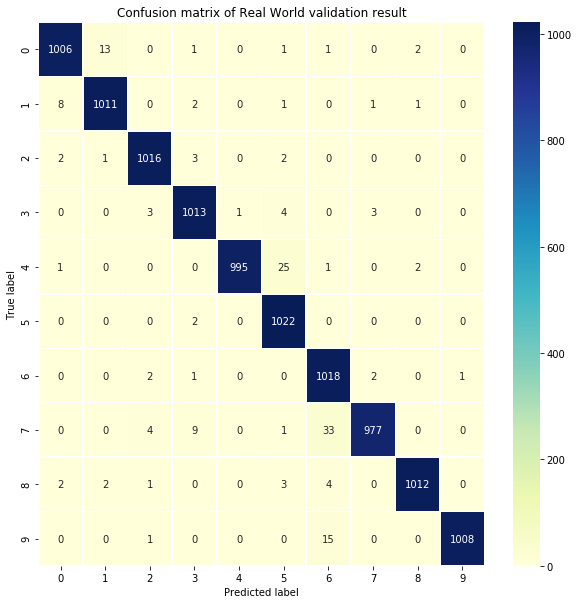

In [19]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

###Confusion matrix
print(classification_report(labels, result,digits=4))
plt.figure(figsize=(10,10))
confusion_mat = confusion_matrix(labels, result)
sn.heatmap(confusion_mat, annot=True, cmap='YlGnBu',fmt="d",linewidths=.5, linecolor='w')
plt.title('Confusion matrix of Real World validation result')
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
# indices1 = np.where(result!=labels)[0]       #(num)
# indices2 = np.where(result_dig!=labels)[0]
# indices3 = np.where((result!=labels)&(result_dig==labels))[0]
indices4 = np.where((result[:,0]==labels))[0]
indices5 = np.where((result[:,0]==labels)|(result[:,1]==labels))[0]
indices6 = np.where((result[:,0]==labels)|(result[:,1]==labels)|(result[:,2]==labels))[0]

cirtic_idx_list_ans0 = []
idx_list_ans1 = []

cirtic_idx_list_ans9 = []
label_list = []
count = 0

data_num = len(labels)
print("top1 acc:",len(indices4)/data_num)
print("top2 acc:",len(indices5)/data_num)
print("top3 acc:",len(indices6)/data_num)
stop

for i in range(0,len(indices1)):
    idx = indices1[i]
#     img1 = global_dig.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
#     img1 = global_pseudo_data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img1 = global_data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img1 = Image.fromarray(img1)
    label1 = result[idx]
#     label2 = result_dig[idx]
    label2 = None
    label = labels[idx]
  

#     if label == 0:
#         fig, axes = plt.subplots(1,1,figsize=(2,2))
# #         cirtic_idx_list_ans0.append(idx)
#         axes.imshow(img1,cmap="gray")
#         print(idx)
#         print("Model:",label1," Model2:",label2," Label:",label)
#         plt.pause(.1)
#     else:
#         continue
        

# print(idx_list_ans1)
# np.save("idx_ans1",idx_list_ans1)

# print(cirtic_idx_list_ans0)
# print(cirtic_idx_list_ans9)

cirtic_idx_list_ans0_v2 = [5520,6150,12280,18560,32730]
np.save("critic_idx_ans0_v2",cirtic_idx_list_ans0_v2)

# plt.figure(figsize=(8,4))
# data = np.uint8(cirtic_label_list)
# print(len(data))
# plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
# plt.xticks(range(10))
# plt.ylabel('frequency')

# plt.figure(figsize=(8,4))
# data = np.uint8(label_list)
# print(len(data))
# plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
# plt.xticks(range(10))
# plt.ylabel('frequency')


# 31 1 0 59969

# Collect top-1 corrected data dig dataset

In [20]:
dig_idx_list = np.array([])
# dig_idx_list = np.load('top1_digidx3.npy')
print(len(dig_idx_list))

indices = np.where((result[:,0]==labels))[0]  #get top1 corrected index
# indices = np.where((result[:,0]==labels)|(result[:,1]==labels))[0]  #get top2 corrected index
dig_idx_list = np.hstack([dig_idx_list,indices])
dig_idx_list = np.unique(dig_idx_list).astype(int)
print(np.shape(dig_idx_list))
np.save("top1_digidx_10k_acc9910.npy",dig_idx_list)


0
(10124,)


# Combine train.csv with dig dataset in top k index

In [22]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

# top1_digidx = np.load("top1_digidx_len9367.npy")
# top1_digidx = np.load("top1_digidx_10k_acc9906.npy")
top1_digidx = np.load("top1_digidx_10k_acc9910.npy")
origin_data = pd.read_csv("./dataset/train.csv")
dig_data = pd.read_csv("./dataset/Dig-MNIST.csv")

train_csv = np.array(origin_data).astype(int)
tmp_csv = np.array(dig_data).astype(int)
print(np.shape(tmp_csv))
top1_dig_csv = []
for idx in top1_digidx:
    top1_dig_csv.append(tmp_csv[idx])

top1_dig_csv = np.array(top1_dig_csv).astype(int)
print(np.shape(top1_dig_csv))
np.savetxt("./dataset/digtop1_10k_acc9910.csv", top1_dig_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')

# new_csv = np.vstack([train_csv,top1_dig_csv])
# np.random.shuffle(new_csv)
# np.random.shuffle(new_csv)
# np.random.shuffle(new_csv)
# print("new_csv_shape:",np.shape(new_csv))
# np.savetxt("./dataset/train_digtop1_69367.csv", new_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')

(10240, 785)
(10124, 785)


# Combine train.csv and Dig augmented, add additional "native writer label"

In [ ]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "native_label,label," + pix_str

origin_data = pd.read_csv("./dataset/train.csv")
dig_aug_data = pd.read_csv("./dataset/Dig-Mnist-Augmented.csv")

In [ ]:
train_csv = np.array(origin_data).astype(int)
dig_aug_csv = np.array(dig_aug_data).astype(int)
native_label0 = np.zeros((60000,1)).astype(int)
native_label1 = np.ones((60000,1)).astype(int)

train_csv = np.concatenate([native_label1,train_csv],axis=1)
dig_aug_csv = np.concatenate([native_label0,dig_aug_csv],axis=1)

print(np.shape(train_csv))
print(np.shape(dig_aug_csv))
new_csv = np.vstack([train_csv,dig_aug_csv])
print(np.shape(new_csv))
np.savetxt("./dataset/train_large.csv", new_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')



# Augment dig dataset

In [ ]:
vr = 0
batch_size = 1024
dataset = KMnistDataset(data_len=None,is_validate=False, validate_rate=vr)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
num_per_class = 6000  # 6000 * 10 =60000

pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

dig_data = pd.read_csv("./dataset/Dig-MNIST.csv")
# dig_data.head(5)


In [ ]:
aug_list = np.empty((0,785))
counter_list = np.zeros((10,)).astype(int)

###Load original 10240 data
origin_img = dig_data.iloc[:, 1:].values.astype(np.uint8).reshape((-1,784))  #value: 0~255
origin_label = np.array(dig_data.iloc[:,0]).astype(int)

for i in range(len(origin_img)):
    if i%1000==0:
        print(i)
    tmp_img = origin_img[i]    #(784,)
    tmp_label = origin_label[i].reshape(-1) #(1,)
    csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
    aug_list = np.vstack((aug_list,csv_arr))
    counter_list[tmp_label] += 1

print("shape of aug_list:",np.shape(aug_list))
print("counter_list:",counter_list)

In [ ]:
###Augment data by random select and affine
keep_loop = True
while keep_loop:
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = img.cpu().numpy()
        img = np.uint8(img*255).reshape(batch_size,-1)
        label = label.cpu().numpy()
        
        for i in range(batch_size):
            tmp_img = img[i]    #(784,)
            tmp_label = label[i].reshape(-1) #(1,)
            if counter_list[tmp_label] >= num_per_class:
                continue
#             print(np.shape(tmp_label),np.shape(tmp_img))
            csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
#             print("csv arr shape:",np.shape(csv_arr))
            
            aug_list = np.vstack((aug_list,csv_arr))
#             print("aug_list shape:",np.shape(aug_list))
            counter_list[tmp_label] += 1

        print("shape of aug_list:",np.shape(aug_list))
        print("counter_list:",counter_list)
        if (counter_list>=num_per_class).all() == True:
            print("Augment Finished")
            print(np.shape(aug_list))
            print(counter_list)
            np.savetxt("./dataset/Dig-Mnist-Augmented.csv", aug_list, delimiter=",",fmt="%d",header=numpy_header,comments='')
            keep_loop = False
            break

# Pseudo labeling

In [14]:
trans_test = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
    ])

class TestDataset(Dataset):
    def __init__(self,data_len=None):
        self.data = pd.read_csv("./dataset/test.csv")
        print("data shape:", np.shape(self.data))
        self.transform = trans_test
        if data_len == None:
            self.len = len(self.data)
        
    def __getitem__(self, idx):
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        return img, torch.Tensor([])

    def __len__(self):
        return self.len
    
test_dataset = TestDataset(data_len=None)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

### Inference models
ensemble_models = []
# ensemble_root = "Kmnist_saved_model/ensemble/5x1fold_65k_senet3_b1024"   #99.00%
# ensemble_root = "Kmnist_saved_model/ensemble/5fold_74k_senet3_augv1"       #99.06%
ensemble_root = "Kmnist_saved_model/ensemble/5fold_75k_senet3_augv1"  #acc99.10

for file_name in os.listdir(ensemble_root):
    if file_name.find("Fold") == -1:
        continue
    model = SE_Net3(in_channels=1)
    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root,file_name)))
    model.eval()
    ensemble_models.append(model)

model_num = len(ensemble_models)
print("model num:",model_num)

psuedo_labels = np.array([])

with torch.no_grad():
    for idx,data in enumerate(test_loader):
            img, label = data
            img, label = img.to(device), label.to(device)

            ###Average Ensemble
            pred_list = torch.Tensor([]).to(device)
            for i in range(model_num):
                pred = ensemble_models[i](img) #(batch_num,10)
                pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
            pred = torch.mean(pred_list,dim=2)   #(batch,10)
            _,pred = torch.max(pred.data, 1)   #(batch_num,)        
    #         _,pred = torch.max(model(img),dim=1)

            psuedo_labels = np.concatenate([psuedo_labels,pred.cpu().numpy()],axis=0)
            data_num += img.size(0)
            
print("Inference complete:",np.shape(psuedo_labels))

data shape: (5000, 785)
model num: 5
Inference complete: (5000,)


In [16]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

test_csv = np.array(pd.read_csv("./dataset/test.csv")).astype(int)[:,1:]

print(np.shape(test_csv))

pseudo_labels = psuedo_labels.reshape(-1,1).astype(int)
print("shape psuedo_labels:",np.shape(psuedo_labels))
test_csv = np.concatenate([pseudo_labels,test_csv],axis=1)

print(np.shape(test_csv))
np.savetxt("./dataset/test_pseu_label_acc9910.csv", test_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')
test_csv = pd.read_csv("./dataset/test_pseu_label_acc9910.csv")
test_csv.head()

(5000, 784)
shape psuedo_labels: (5000,)
(5000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Augmented psuedo_label test dataset

In [ ]:
trans_aug = transforms.Compose([
        transforms.ColorJitter(0.5,0.2,0,0),
        transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
    ])

class AugDataset(Dataset):
    def __init__(self,data_len=None):
        self.data = pd.read_csv("./dataset/test_psuedo_label.csv")
        print("data shape:", np.shape(self.data))
        self.transform = trans_aug
        if data_len == None:
            self.len = len(self.data)
        
    def __getitem__(self, idx):
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

vr = 0
batch_size = 1024
dataset = AugDataset(data_len=None)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=10)
num_per_class = 6000  # 6000 * 10 =60000
aug_list = np.empty((0,785))
counter_list = np.zeros((10,)).astype(int)
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str
    
###Augment data by random select and affine
keep_loop = True
while keep_loop:
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = img.cpu().numpy()
        img = np.uint8(img*255).reshape(-1,784)
        label = label.cpu().numpy()
        
        for i in range(img.shape[0]):
            tmp_img = img[i]    #(784,)
            tmp_label = label[i].reshape(-1) #(1,)
            if counter_list[tmp_label] >= num_per_class:
                continue
#             print(np.shape(tmp_label),np.shape(tmp_img))
            csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
#             print("csv arr shape:",np.shape(csv_arr))
            
            aug_list = np.vstack((aug_list,csv_arr))
#             print("aug_list shape:",np.shape(aug_list))
            counter_list[tmp_label] += 1

        print("shape of aug_list:",np.shape(aug_list))
        print("counter_list:",counter_list)
        if (counter_list>=num_per_class).all() == True:
            print("Augment Finished")
            print(np.shape(aug_list))
            print(counter_list)
            np.savetxt("./dataset/test_psuedo_augmented.csv", aug_list, delimiter=",",fmt="%d",header=numpy_header,comments='')
            keep_loop = False
            break

# Combine train.csv with test_psuedo_aug.csv

In [24]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

train_csv = np.array(pd.read_csv("./dataset/train.csv")).astype(int)
# test_csv = np.array(pd.read_csv("./dataset/test_psuedo_labelv2.csv")).astype(int)
test_csv = np.array(pd.read_csv("./dataset/test_pseu_label_acc9910.csv")).astype(int)
digtop1_csv = np.array(pd.read_csv("./dataset/digtop1_10k_acc9910.csv")).astype(int)
# test_csv = np.array(pd.read_csv("./dataset/test_psuedo_augmented.csv")).astype(int)

# indices = np.where(test_csv[:,0]!=test_csv2[:,0])[0]
# print(len(indices))

print(np.shape(train_csv))
print(np.shape(test_csv))
print(np.shape(digtop1_csv))

new_csv = np.vstack([train_csv,test_csv,digtop1_csv])
for i in range(5):
    np.random.shuffle(new_csv)  #Multi-dimensional arrays are only shuffled along the first axis:

print(np.shape(new_csv))
np.savetxt("./dataset/train_pseu_dig_75k_acc9910.csv", new_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')


(60000, 785)
(5000, 785)
(10124, 785)
(75124, 785)


# Augmented train dataset with critic example

In [ ]:
 global_data = pd.read_csv("./dataset/train.csv")

In [ ]:
trans_aug = transforms.Compose([
        transforms.ColorJitter(0.9,0.2,0,0),
        transforms.RandomAffine(degrees=20,translate=(0.1,0.05),scale=(0.8,1.05)),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
    ])

class AugDataset(Dataset):
    def __init__(self,critic_idx_list=None):
        self.data = global_data
        self.transform = trans_aug
        self.critic_idx_list = critic_idx_list
        print("data len:", np.shape(self.critic_idx_list))
        self.len = len(critic_idx_list)
        
        
    def __getitem__(self, idx):
        idx = self.critic_idx_list[idx]
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

batch_size = 10
critic_idx_list = np.load("./critic_idx_ans0.npy")
# critic_idx_list = np.load("./idx_ans1.npy")
dataset = AugDataset(critic_idx_list)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
aug_list = np.empty((0,785))
counter_list = np.zeros((10,)).astype(int)
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str
    
###Augment data by random select and affine
data_num = 0
for ep in range(50000):
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = img.cpu().numpy()
        img = np.uint8(img*255).reshape(-1,784)
        label = label.cpu().numpy().reshape(-1,1)
        
#         batch_num = np.shape(img)[0]
#         fig,axes = plt.subplots(1,batch_num,figsize=(10,2))
#         for i in range(batch_num):
#             axes[i].imshow(img[i].reshape(28,28),cmap='gray')
#         plt.pause(.1)
        
        csv_arr = np.hstack([label,img])
        aug_list = np.vstack([aug_list,csv_arr])
        data_num += img.shape[0]
        if data_num %2000==0:
            print(data_num)
        if data_num > 10000:
            print("shape of aug_list:",np.shape(aug_list))
            aug_list = aug_list[:10000]
            np.savetxt("./dataset/critic0_10k_complicated.csv", aug_list, delimiter=",",fmt="%d",header=numpy_header,comments='')
            stop


# Combine label1_10k with critic0_10k

In [ ]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

critic0_csv = np.array(pd.read_csv("./dataset/critic0_10k_complicated.csv")).astype(int)
label1_csv = np.array(pd.read_csv("./dataset/label1_10k.csv")).astype(int)

print(np.shape(critic0_csv))
print(np.shape(label1_csv))
new_csv = np.vstack([critic0_csv,label1_csv])
np.random.shuffle(new_csv)  #Multi-dimensional arrays are only shuffled along the first axis:
np.random.shuffle(new_csv)
np.random.shuffle(new_csv)

print(np.shape(new_csv))
np.savetxt("./dataset/critic01_20k_complicated.csv", new_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')


# Show data distribution

In [ ]:
# data = np.random.random([1000,])
# global_data = pd.read_csv("./dataset/train_large.csv")
global_data = pd.read_csv("./dataset/train.csv")
# global_data_test = pd.read_csv("./dataset/train_test_psuedo_aug.csv")
global_data_test = pd.read_csv("./dataset/train_test_psuedo_65k.csv")

# data1 = global_data.iloc[:10,1:]
# data2 = global_data_test.iloc[:,0]

train_digtop1= pd.read_csv("./dataset/digtop1_9548.csv")
plt.hist(train_digtop1 ,density=0,label=True,rwidth=0.3)
plt.xticks(range(0,10))

# print((label==5).sum().item())
# plt.ylabel('frequency')

